# Water Clasification Random Forest CPU

Version: DEMO

ILAB Team

Kernel to use:
- (ADAPT PRISM) `Python [conda env:ilab]`

This is a demo notebook showcasing how the ILAB team uses sklearn capabilities to perform efficient CPU-based training of a Random Forest classifier algorithm. This notebook also demonstates how to use a raster as a test data-set for the trained model.

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys
from pprint import pprint
import time

import optuna

# Scikit learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
DATA_TYPE = np.float32

In [3]:
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

Add names from above to this list to drop them from training and testing.

For example:

```python
columnsToDrop = ['sur_refl_b01_1', 'sur_refl_b07_1', 'ndwi1']
```

In [4]:
columnsToDrop = []

This is a 1000 row training dataset which has columns for all the features listed in v_names. MODIS MOD09GA and MOD09GQ were the data sources.

In [5]:
dfPath = '../data/WaterClassificationPowell.parquet.gzip'

In [6]:
outputRasterPath = '.'

In [7]:
!pip install fastparquet

In [8]:
df = pd.read_parquet(dfPath).astype(DATA_TYPE)
df = df.drop(columns=columnsToDrop)
X = df.drop(['water'], axis=1)
y = df['water']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

## Load in data for use of visualizations 
(skip this if you just want to train model)

In [10]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [11]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,800.0,1234.660034,1353.554565,8.000000,233.000000,877.000000,1915.000000,9222.000000
sur_refl_b02_1,800.0,1586.628784,1603.414185,1.000000,163.000000,1241.500000,2697.750000,8837.000000
sur_refl_b03_1,800.0,763.526245,1079.617798,-100.000000,279.000000,548.000000,857.000000,8909.000000
sur_refl_b04_1,800.0,1047.535034,1130.636719,6.000000,406.750000,819.000000,1312.000000,9162.000000
sur_refl_b05_1,800.0,1954.098755,1478.039917,-92.000000,538.500000,1757.500000,3213.250000,6382.000000
sur_refl_b06_1,800.0,1907.581299,1542.750122,56.000000,503.750000,1445.500000,3253.000000,6610.000000
sur_refl_b07_1,800.0,1569.521240,1399.778320,0.000000,300.750000,1133.500000,2740.500000,6128.000000
ndvi,800.0,-8.354029,2539.749512,-9493.670898,-1630.924561,566.527252,1723.163544,6732.558105
ndwi1,800.0,-2337.522705,3517.485107,-9829.059570,-4632.356689,-1638.265198,-780.138382,8823.803711
ndwi2,800.0,-879.903748,3963.966064,-9615.384766,-2848.157837,-696.361206,860.248474,10000.000000


## Random Forest Model

### Model Definition

In [12]:
def objective(trial):
    hyperparameters = {
        "n_jobs": -1,
        # The number of trees in the forest.
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 150, 200, 250, 300, 350, 400]),
        # The function to measure the quality of a split.
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        # The maximum depth of the tree. 
        # If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
        "max_depth": trial.suggest_categorical("max_depth", [None, 16, 32, 64]),
        # The minimum number of samples required to split an internal node.
        "min_samples_split":  trial.suggest_float("min_samples_split", 0.1, 1),
        # The number of features to consider when looking for the best split.
        "max_features":  trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
    }
    classifier = RandomForestClassifier(**hyperparameters)
    scores = []
    for trainIdx, testIdx in kf.split(X_train):
        X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
        y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
        classifier.fit(X_train_valid, y_train_valid)
        preds = classifier.predict(X_test_valid)
        f1 = f1_score(y_test_valid, preds)
        print('F1 Score: {}'.format(f1))
        scores.append(f1)
    print('Mean F1 score: {}'.format(sum(scores)/len(scores)))
    return f1

## Set the search space

Set the search space for the hyperparameter tuning to search through once. This needs to be in conjunction with the `trial.suggest...` part of the hyperparameters dictionary defined aboce. 

Ex.

If `max_depth` is defined in `hyperparameters` in the `objective` function above as such

`"max_depth":  trial.suggest_int("max_depth", 3, 15, step=1),` 

then we need to pair that with the limited search space below as such:

`search_space={"max_depth":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}`

This is not the most ideal way of ensuring that trials are not repeated, however it works for now. 

In [13]:
search_space={
    "max_depth":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
}

### Set number of trials and timeout

Set the number of trials `n_trials=<num of desired trials>` and the maximum time for the total study `timeout=<timeout in minutes>*60`

In [14]:
optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(study_name='rf hyperparameter tuning - cpu', 
                            direction='maximize',
                           ) # sampler=optuna.samplers.GridSampler(search_space))

study.optimize(objective, n_trials=20, timeout=10*60)

[I 2022-08-17 10:52:43,954] A new study created in memory with name: rf hyperparameter tuning - cpu


F1 Score: 0.6885245901639345
F1 Score: 0.6440677966101694
F1 Score: 0.6721991701244813
F1 Score: 0.0


[I 2022-08-17 10:52:46,012] Trial 0 finished with value: 0.649789029535865 and parameters: {'n_estimators': 300, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 0.7226871167264274, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.649789029535865.


F1 Score: 0.649789029535865
Mean F1 score: 0.53091611728689
F1 Score: 0.6885245901639345
F1 Score: 0.6440677966101694
F1 Score: 0.6721991701244813
F1 Score: 0.9424083769633509


[I 2022-08-17 10:52:47,278] Trial 1 finished with value: 0.649789029535865 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 64, 'min_samples_split': 0.6565771496446408, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.649789029535865.


F1 Score: 0.649789029535865
Mean F1 score: 0.7193977926795602
F1 Score: 0.962962962962963
F1 Score: 0.9801324503311258
F1 Score: 0.949367088607595


[I 2022-08-17 10:52:47,978] Trial 2 finished with value: 0.953020134228188 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': 64, 'min_samples_split': 0.625726684012013, 'max_features': None}. Best is trial 2 with value: 0.953020134228188.


F1 Score: 0.9841269841269841
F1 Score: 0.953020134228188
Mean F1 score: 0.9659219240513712
F1 Score: 0.9818181818181818
F1 Score: 0.9866666666666666
F1 Score: 0.9629629629629629
F1 Score: 0.983957219251337


[I 2022-08-17 10:52:49,401] Trial 3 finished with value: 0.9600000000000001 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 0.241665305642925, 'max_features': None}. Best is trial 3 with value: 0.9600000000000001.


F1 Score: 0.9600000000000001
Mean F1 score: 0.9750810061398296
F1 Score: 0.9696969696969696
F1 Score: 0.9933774834437086
F1 Score: 0.9625
F1 Score: 0.9841269841269841


[I 2022-08-17 10:52:50,748] Trial 4 finished with value: 0.9668874172185431 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_split': 0.6300688812438315, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.9668874172185431
Mean F1 score: 0.975317770897241
F1 Score: 0.6885245901639345
F1 Score: 0.6440677966101694
F1 Score: 0.6721991701244813
F1 Score: 0.0


[I 2022-08-17 10:52:52,078] Trial 5 finished with value: 0.649789029535865 and parameters: {'n_estimators': 200, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 0.7312942142229891, 'max_features': 'log2'}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.649789029535865
Mean F1 score: 0.53091611728689
F1 Score: 0.9696969696969696
F1 Score: 0.9868421052631579
F1 Score: 0.9625
F1 Score: 0.9841269841269841


[I 2022-08-17 10:52:54,854] Trial 6 finished with value: 0.9600000000000001 and parameters: {'n_estimators': 400, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 0.42307389329376865, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.9600000000000001
Mean F1 score: 0.9726332118174223
F1 Score: 0.9818181818181818
F1 Score: 0.9933774834437086
F1 Score: 0.9689440993788819


[I 2022-08-17 10:52:55,599] Trial 7 finished with value: 0.9668874172185431 and parameters: {'n_estimators': 100, 'criterion': 'gini', 'max_depth': 16, 'min_samples_split': 0.20243544566323424, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.9893617021276596
F1 Score: 0.9668874172185431
Mean F1 score: 0.9800777767973952
F1 Score: 0.975609756097561
F1 Score: 0.9801324503311258
F1 Score: 0.949367088607595
F1 Score: 0.9841269841269841


[I 2022-08-17 10:52:56,778] Trial 8 finished with value: 0.953020134228188 and parameters: {'n_estimators': 150, 'criterion': 'gini', 'max_depth': 64, 'min_samples_split': 0.6384437317264486, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.953020134228188
Mean F1 score: 0.9684512826782908
F1 Score: 0.9818181818181818
F1 Score: 0.9933774834437086
F1 Score: 0.9693251533742332
F1 Score: 0.9841269841269841


[I 2022-08-17 10:52:58,335] Trial 9 finished with value: 0.9668874172185431 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 0.26036474578860513, 'max_features': 'log2'}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.9668874172185431
Mean F1 score: 0.9791070439963303
F1 Score: 0.6885245901639345
F1 Score: 0.6440677966101694
F1 Score: 0.6721991701244813
F1 Score: 0.0


[I 2022-08-17 10:52:59,828] Trial 10 finished with value: 0.649789029535865 and parameters: {'n_estimators': 250, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 0.9198023171658878, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.649789029535865
Mean F1 score: 0.53091611728689
F1 Score: 0.9818181818181818
F1 Score: 0.9866666666666666
F1 Score: 0.9629629629629629


[I 2022-08-17 10:53:00,556] Trial 11 finished with value: 0.9600000000000001 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 0.1009705737820918, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.983957219251337
F1 Score: 0.9600000000000001
Mean F1 score: 0.9750810061398296
F1 Score: 0.975609756097561
F1 Score: 0.9801324503311258
F1 Score: 0.949367088607595
F1 Score: 0.9841269841269841


[I 2022-08-17 10:53:02,772] Trial 12 finished with value: 0.953020134228188 and parameters: {'n_estimators': 350, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 0.4865674466662839, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.953020134228188
Mean F1 score: 0.9684512826782908
F1 Score: 0.6885245901639345
F1 Score: 0.6440677966101694
F1 Score: 0.6721991701244813


[I 2022-08-17 10:53:03,487] Trial 13 finished with value: 0.649789029535865 and parameters: {'n_estimators': 100, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 0.8613226668403394, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.0
F1 Score: 0.649789029535865
Mean F1 score: 0.53091611728689
F1 Score: 0.975609756097561
F1 Score: 0.9801324503311258
F1 Score: 0.949367088607595
F1 Score: 0.9841269841269841


[I 2022-08-17 10:53:05,448] Trial 14 finished with value: 0.953020134228188 and parameters: {'n_estimators': 300, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 0.3821607335109874, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.953020134228188
Mean F1 score: 0.9684512826782908
F1 Score: 0.9818181818181818
F1 Score: 0.9933774834437086
F1 Score: 0.9629629629629629
F1 Score: 0.983957219251337
F1 Score: 0.9600000000000001
Mean F1 score: 0.9764231694952381


[I 2022-08-17 10:53:06,494] Trial 15 finished with value: 0.9600000000000001 and parameters: {'n_estimators': 150, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 0.12398924808660267, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.975609756097561
F1 Score: 0.9866666666666666
F1 Score: 0.949367088607595
F1 Score: 0.9789473684210526


[I 2022-08-17 10:53:08,187] Trial 16 finished with value: 0.953020134228188 and parameters: {'n_estimators': 250, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 0.3182325997844304, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.953020134228188
Mean F1 score: 0.9687222028042125
F1 Score: 0.975609756097561
F1 Score: 0.9801324503311258
F1 Score: 0.949367088607595
F1 Score: 0.9841269841269841


[I 2022-08-17 10:53:10,508] Trial 17 finished with value: 0.953020134228188 and parameters: {'n_estimators': 350, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_split': 0.5231038755282286, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.953020134228188
Mean F1 score: 0.9684512826782908
F1 Score: 0.6885245901639345
F1 Score: 0.6440677966101694
F1 Score: 0.6721991701244813
F1 Score: 0.0


[I 2022-08-17 10:53:12,840] Trial 18 finished with value: 0.649789029535865 and parameters: {'n_estimators': 400, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 0.8504055919889062, 'max_features': None}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.649789029535865
Mean F1 score: 0.53091611728689
F1 Score: 0.6885245901639345
F1 Score: 0.6440677966101694
F1 Score: 0.6721991701244813
F1 Score: 0.0


[I 2022-08-17 10:53:14,128] Trial 19 finished with value: 0.649789029535865 and parameters: {'n_estimators': 200, 'criterion': 'gini', 'max_depth': 32, 'min_samples_split': 0.9937237227550308, 'max_features': 'log2'}. Best is trial 4 with value: 0.9668874172185431.


F1 Score: 0.649789029535865
Mean F1 score: 0.53091611728689


In [15]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_rf.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 20
{'n_estimators': 200, 'criterion': 'entropy', 'max_depth': 32, 'min_samples_split': 0.6300688812438315, 'max_features': 'sqrt'}
0.9668874172185431


In [16]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_criterion,params_max_depth,params_max_features,params_min_samples_split,params_n_estimators,state
0,0,0.649789,2022-08-17 10:52:43.956298,2022-08-17 10:52:46.012004,0 days 00:00:02.055706,gini,16.0,sqrt,0.722687,300,COMPLETE
1,1,0.649789,2022-08-17 10:52:46.013841,2022-08-17 10:52:47.277928,0 days 00:00:01.264087,gini,64.0,sqrt,0.656577,200,COMPLETE
2,2,0.953020,2022-08-17 10:52:47.278654,2022-08-17 10:52:47.978265,0 days 00:00:00.699611,entropy,64.0,None,0.625727,100,COMPLETE
3,3,0.960000,2022-08-17 10:52:47.979088,2022-08-17 10:52:49.400997,0 days 00:00:01.421909,entropy,16.0,None,0.241665,200,COMPLETE
4,4,0.966887,2022-08-17 10:52:49.401814,2022-08-17 10:52:50.748660,0 days 00:00:01.346846,entropy,32.0,sqrt,0.630069,200,COMPLETE
5,5,0.649789,2022-08-17 10:52:50.749377,2022-08-17 10:52:52.077820,0 days 00:00:01.328443,entropy,NaN,log2,0.731294,200,COMPLETE
6,6,0.960000,2022-08-17 10:52:52.078779,2022-08-17 10:52:54.853879,0 days 00:00:02.775100,gini,16.0,sqrt,0.423074,400,COMPLETE
7,7,0.966887,2022-08-17 10:52:54.854612,2022-08-17 10:52:55.599240,0 days 00:00:00.744628,gini,16.0,sqrt,0.202435,100,COMPLETE
8,8,0.953020,2022-08-17 10:52:55.600405,2022-08-17 10:52:56.778199,0 days 00:00:01.177794,gini,64.0,None,0.638444,150,COMPLETE
9,9,0.966887,2022-08-17 10:52:56.779086,2022-08-17 10:52:58.334910,0 days 00:00:01.555824,gini,32.0,log2,0.260365,200,COMPLETE


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

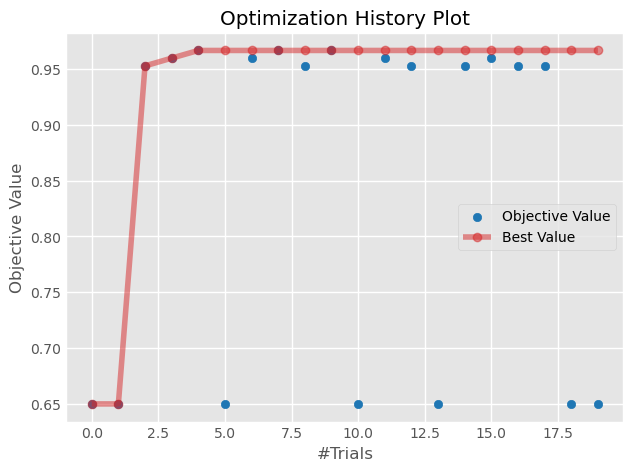

In [17]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

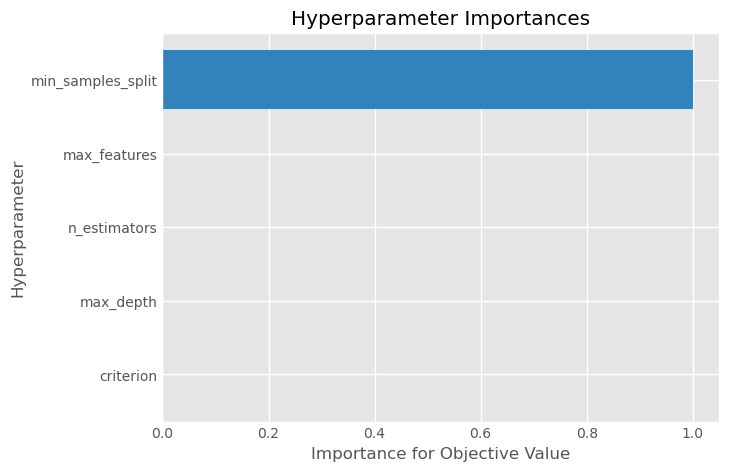

In [18]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,800.0,1257.017456,1343.986084,15.000000,246.000000,924.500000,1927.000000,9222.000000
sur_refl_b02_1,800.0,1640.077515,1600.745728,1.000000,179.500000,1488.000000,2720.500000,8837.000000
sur_refl_b03_1,800.0,768.756226,1065.279541,-100.000000,291.500000,562.000000,861.250000,8909.000000
sur_refl_b04_1,800.0,1057.439941,1120.644287,14.000000,416.500000,824.000000,1348.500000,9162.000000
sur_refl_b05_1,800.0,1993.836304,1474.103882,-92.000000,555.500000,1874.000000,3250.500000,5706.000000
sur_refl_b06_1,800.0,1938.288696,1542.548096,51.000000,522.000000,1473.500000,3254.250000,5812.000000
sur_refl_b07_1,800.0,1585.051270,1394.620239,0.000000,322.250000,1172.500000,2728.500000,5132.000000
ndvi,800.0,103.408966,2604.520508,-9493.670898,-1442.421295,778.583252,1771.562195,8587.457031
ndwi1,800.0,-2218.255371,3488.194336,-9862.069336,-4529.400879,-1556.404297,-710.971405,8823.803711
ndwi2,800.0,-766.403076,3889.526367,-9692.307617,-2509.427124,-623.491943,893.924866,10000.000000


In [21]:
hyperparameters = best_trial_params

base_params = {"n_jobs": -1}

hyperparameters.update(base_params)
print('Using these params:')
pprint(hyperparameters)
classifier = RandomForestClassifier(**hyperparameters)

Using these params:
{'criterion': 'entropy',
 'max_depth': 32,
 'max_features': 'sqrt',
 'min_samples_split': 0.6300688812438315,
 'n_estimators': 200,
 'n_jobs': -1}


In [22]:
%%time

classifier.fit(X_train, y_train)

CPU times: user 386 ms, sys: 89.1 ms, total: 475 ms
Wall time: 235 ms


RandomForestClassifier(criterion='entropy', max_depth=32,
                       min_samples_split=0.6300688812438315, n_estimators=200,
                       n_jobs=-1)

### Get model metrics

In [23]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.97

In [24]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [25]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [26]:
print('Train Performance')
print('-------------------------------------------------------')
print(classification_report(y_train, train_predictions))
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Train Performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       404
         1.0       0.99      0.96      0.98       396

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97        96
         1.0       0.97      0.97      0.97       104

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200

Test Recall
-------------------------------------------------------
0.96875
Confusion Matrix
-------------------------------------------------------
[[ 93   3]
 [  3 101]]


In [27]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

CPU times: user 2.41 s, sys: 634 ms, total: 3.05 s
Wall time: 2.56 s


Text(0.5, 0, 'Permutation Importance')

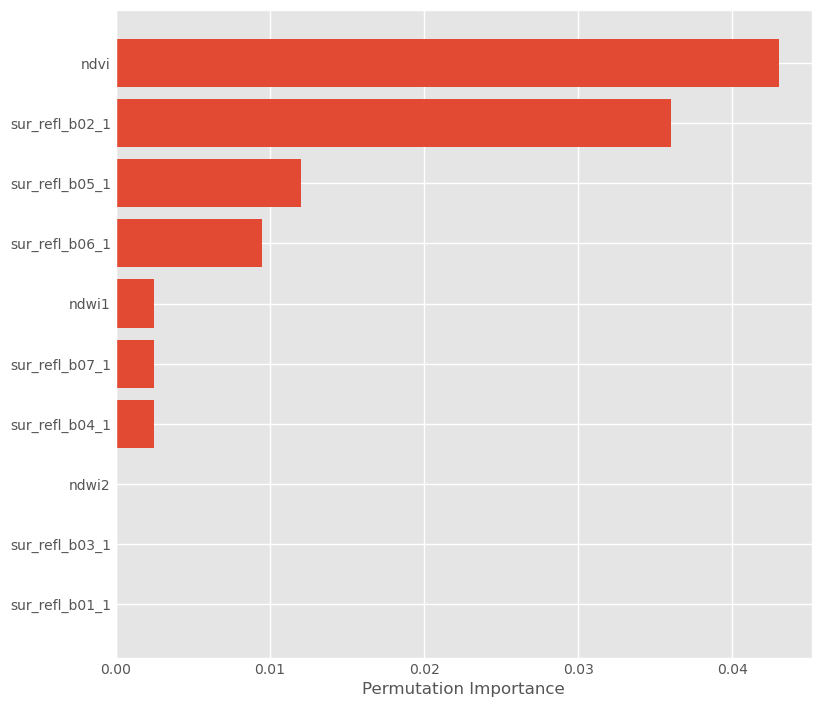

In [28]:
sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [29]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, prediction_probs, y_test_int

## Save the model for future use

In [30]:
model_save_path = './water_classifier_rf_cpu.sav'
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: ./water_classifier_rf_cpu.sav
RandomForestClassifier(criterion='entropy', max_depth=32,
                       min_samples_split=0.6300688812438315, n_estimators=200,
                       n_jobs=-1)


['./water_classifier_rf_cpu.sav']

# Testing: Raster testing

### Read in data 

These are modified MOD09GA and MOD09GQ products for the 2001 julian day 155. They were modified to be clipped to the Lake Powell region.

In [31]:
fileList = sorted([file for file in glob.glob('../data/IL.*.Powell.*.tif') if 'sur_refl' in file])

In [32]:
def readRastersToArray(fileList):
    rasterProjection = None
    newshp = (1300*1300, 10)
    img = np.empty(newshp, dtype=np.int16)
    for i, fileName in enumerate(fileList):
        ds = gdal.Open(fileName)
        img[:, i] = ds.GetRasterBand(1).ReadAsArray().astype(np.int16).ravel()
        if i == 0:
            rasterProjection = ds.GetProjection()
        ds = None
    img[:, len(fileList)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(fileList)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(fileList)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    return img, rasterProjection

In [33]:
%%time
im, rasterProjection = readRastersToArray(fileList)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 1547  2461   857 ...  2280  -518   510]
 [ 1474  2377   857 ...  2344  -691   337]
 [ 1474  2377   846 ...  2344  -472   623]
 ...
 [ 2358  2979  1028 ...  1163 -1727 -1292]
 [ 2425  3069  1117 ...  1172 -1721 -1216]
 [ 2402  3038  1117 ...  1169 -1770 -1266]]
33.8 MB size
CPU times: user 205 ms, sys: 37.1 ms, total: 242 ms
Wall time: 362 ms


### Load in the model

In [34]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    print('Converting host array to CPU-based dataframe')
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.float32)
    df = df.drop(columns=columnsToDrop)
    print('Making predictions from raster')
    predictions = classifier.predict(df)
    predictionsProbs = classifier.predict_proba(df)
    return predictions, predictionsProbs, df

In [35]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im)

Converting host array to CPU-based dataframe
Making predictions from raster
CPU times: user 47.7 s, sys: 3.97 s, total: 51.7 s
Wall time: 6.55 s


### Description of the predicted probability for each pixel in the raster (no bad-data vals masked yet)

In [36]:
shp = (1300, 1300)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [37]:
shp = (1300, 1300)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(1300, 1300)

Add QA mask to prediction

In [38]:
qa = [file for file in glob.glob('../data/*.tif') if 'qa' in file][0]
ds = gdal.Open(qa)
qaMask = ds.GetRasterBand(1).ReadAsArray()
output = np.where(qaMask == 0, reshp, -9999)
qaMask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

In [39]:
countNoData = np.count_nonzero(output == -9999)
countLand = np.count_nonzero(output == 0)
countWater = np.count_nonzero(output == 1)
print('Predicted\n No-data occuraces: {}\n Land occurances: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 No-data occuraces: 61568
 Land occurances: 1619738
 Water occurances: 8694


## Output predicted raster to GeoTiff

In [40]:
geoTransform = (-9961223.407, 231.65635, 0.0, 4285642.633667, 0.0, -231.65635)

In [41]:
predictedPath = os.path.join(outputRasterPath, 'PowellPredictedWaterMask.tif')

driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(predictedPath, 1300, 1300, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geoTransform)
outDs.SetProjection(rasterProjection)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(output)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

## View predictions with Folium

In [43]:
import folium
from folium import plugins

sys.path.append('../scripts')
import folium_helper

In [44]:
mask_3857 = folium_helper.reproject_to_3857(predictedPath)
mask_d = folium_helper.get_bounds(mask_3857)
mask_b1 = folium_helper.open_and_get_band(mask_3857, 1)
folium_helper.cleanup(mask_3857)
mask_b1 = np.where(mask_b1 == -9999, 0, mask_b1)
zeros = np.zeros_like(mask_b1)
mask_rgb = np.dstack((mask_b1, zeros, zeros))

Transform: | 491.82, 0.00,-12749861.52|
| 0.00,-491.82, 4656230.30|
| 0.00, 0.00, 1.00|
Width: 1670 Height: 770


In [45]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google')


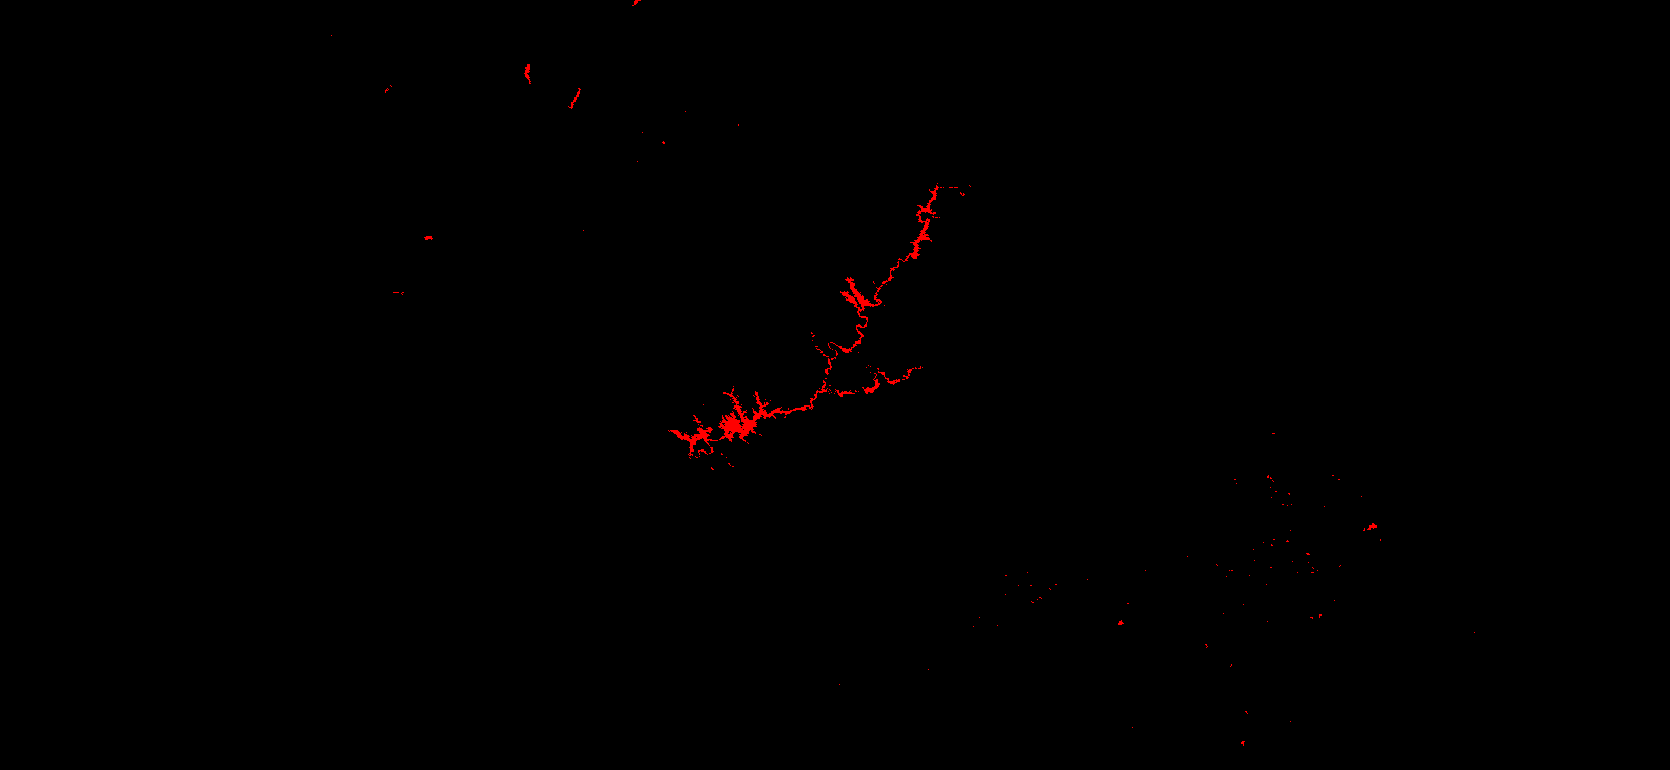

In [46]:
m.add_child(folium_helper.get_overlay(mask_rgb, mask_d, 'Water classification XGBOOST predicted mask', opacity=0.6))
m.add_child(plugins.MousePosition())
m.add_child(folium.LayerControl())